# The void topology

We want to identify voids in cosmic simulations using topological data analysis (TDA). We'll make use of TDA to obtain persisting features around void basins. In this two-dimensional demo notebook, the features we're looking for will be $1$-cycles or loops.

A proper analysis has also been done in three dimensions (check out [this](https://fse.studenttheses.ub.rug.nl/25287/) BSc thesis, where we compared TDA voids with voids determined using the [Watershed Void Finder (WVF)](https://academic.oup.com/mnras/article/380/2/551/1010947)), though for sake of speed we stick to two dimensions here.

Already in two dimensions, however, we get a beautiful view into how TDA allows us to explore hierarchical networks and multi-scale structures. The Universe is full of both - on large, cosmic scales as well as on much smaller scales here on Earth.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.measure import EllipseModel

import gudhi

from tqdm.auto import tqdm

# plot settings for later
color_dict = {0: 'r', 1: 'xkcd:goldenrod',2: 'b'}

## Load data

The data for this notebook consist of a single 2d slice at redshift $z=0
$ of a $\Lambda$CDM $N$-body simulation. 

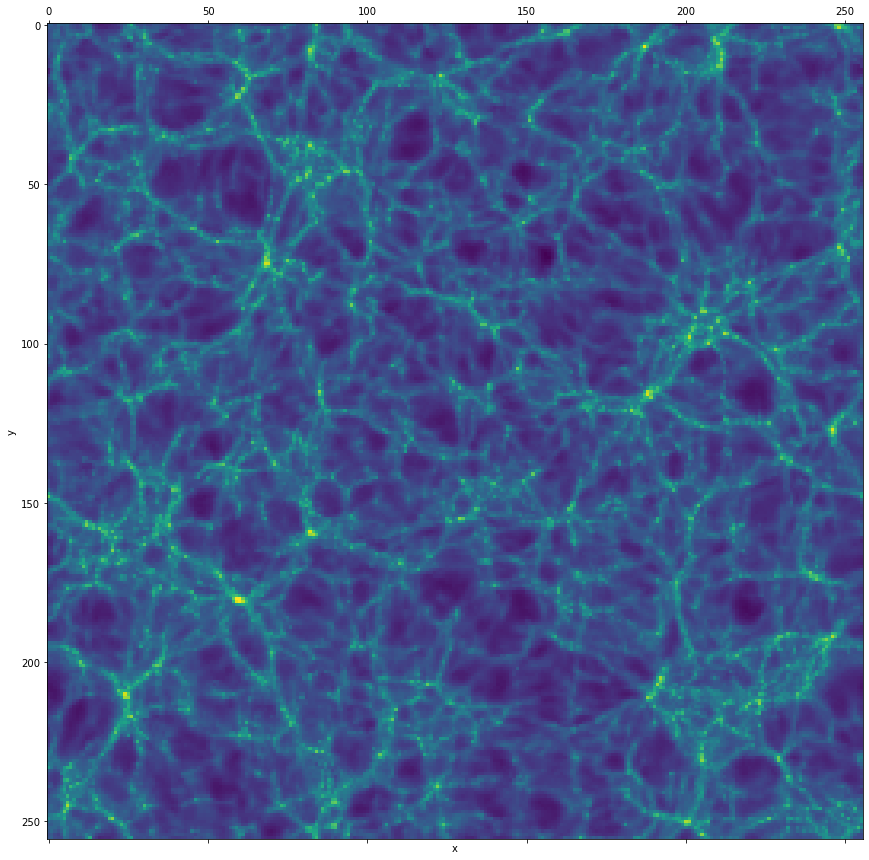

In [2]:
# load
density_slice = np.load('./data/density_files/densityslice_LCDM_15_007.npy')
# convert to log
density_slice = np.log10(density_slice)

# work in pixel units
L = density_slice.shape
N = np.prod(L)
periodic_dimensions = (True,True)

# this is how the slice through the simulation looks
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.matshow(density_slice)
ax.set_xlabel('x');
ax.set_ylabel('y');

## Calculate persistence

Add description...

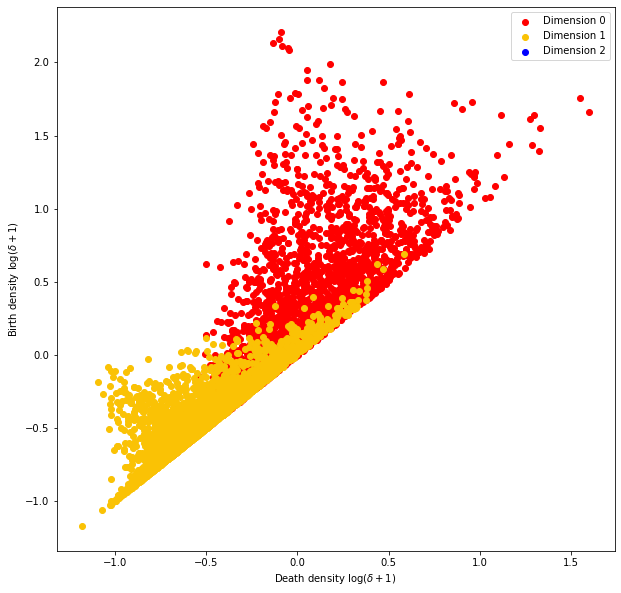

In [3]:
# cubical complex
p_cubical_field = gudhi.PeriodicCubicalComplex(dimensions=density_slice.shape,
                                               top_dimensional_cells=-density_slice.flatten(),
                                               periodic_dimensions=periodic_dimensions)
# sub-level persistence
persistence_cubical = p_cubical_field.persistence()
# invert back to super-level persitence
pers_inverted = [ (pi[0], (-pi[1][1],-pi[1][0])) for pi in persistence_cubical]
# get the occuring dimensions
dimensions = set([p[0] for p in pers_inverted])
# store peristence points as array instead of list of tuples
pers_array = np.array([ [int(p[0]),p[1][0],p[1][1]] for p in pers_inverted for d in dimensions if p[0]==d ])
pers_list = [np.array(pers_array[pers_array[:,0]==d,:]) for d in dimensions]
# sort for descending persistences
pers_list = [ pl[np.argsort(pl[:,2]-pl[:,1])[::-1],:] for pl in pers_list]

fig, ax = plt.subplots(1,1,figsize=(10,10))
for dim in [0,1,2]:
    ax.scatter(pers_list[dim][:,1],pers_list[dim][:,2],
               c=color_dict[dim],label=r'Dimension %i'%dim)
ax.legend()
ax.set_xlabel(r'Death density $\log(\delta+1)$');
ax.set_ylabel(r'Birth density $\log(\delta+1)$');

## Void exploration

  0%|          | 0/500 [00:00<?, ?it/s]

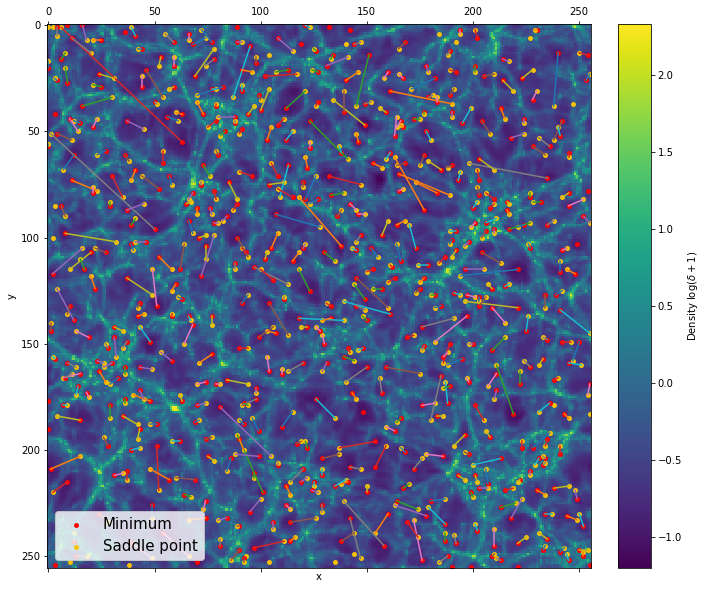

In [4]:
# let's explore the voids and critical points
# select how many voids
N = 500
# calculate, and plot lines between void centre -> void saddle
fig, ax = plt.subplots(1,1,figsize=(10,10))
im = ax.matshow(density_slice)
#start with empty list
void_list = []
# loop through all one-dimensional persistence pairs
# this signify the formation of a closed loop (=death) surrounding a void (at a saddle point)
# and the filling of the loop (=birth) at the centre of the void (at a minimum)
for death,birth in zip(tqdm(pers_list[1][:N,1]),pers_list[1][:N,2]):
    # we want to exclude the two loops at infinite of the ambient space
    if death > -np.inf:
        # get locations (=indices) where the loop is born and dies
        loc_void = np.where(density_slice == death)
        loc_saddle = np.where(density_slice == birth)

        # also calculate the distance between the saddle point and the minimum
        distance_raw = np.array([loc_saddle[0][0],loc_saddle[1][0]]) - np.array([loc_void[0][0],loc_void[1][0]])
        # correct for periodicity (recheck this)
        distance_temp = np.sum(np.min([np.abs(distance_raw),np.abs(distance_raw-L)],0)**2)**0.5
        # store void centre in list
        void_list.append([loc_void[1][0],loc_void[0][0],
                          loc_saddle[1][0],loc_saddle[0][0],
                          birth,
                          death,
                          distance_temp])
        # add saddle point and minimum to plot
        ax.scatter(loc_void[1],loc_void[0],marker='o',s=15,c='r')
        ax.scatter(loc_saddle[1],loc_saddle[0],marker='o',s=15,c='xkcd:goldenrod')
        # add connecting vector, but only of saddle point and central void minimum
        # are NOT separated by an boundary of the box
        if max(np.abs(distance_raw)) < min(L)/2:
            ax.plot([loc_void[1],loc_saddle[1]],[loc_void[0],loc_saddle[0]])
# dummy plots for legends
ax.scatter(np.nan,np.nan,marker='o',s=15,c='r',label='Minimum')
ax.scatter(np.nan,np.nan,marker='o',s=15,c='xkcd:goldenrod',label='Saddle point')
inset_ax = ax.inset_axes((1.05,0,0.06,1))
cbar = fig.colorbar(im, cax=inset_ax, orientation='vertical')
cbar.ax.set_ylabel(r'Density $\log(\delta+1)$')
ax.legend(fontsize=15)
ax.set_xlabel(r'x');
ax.set_ylabel(r'y');
void_list = np.array(void_list)

## Void watersheds

In [5]:
# Fill voids
# we essentially use a watershed algorithm to flood the voids
# starting from the centre, and upto a certain threshold

L1,L2 = density_slice.shape

# fraction of (density_saddle-density_centre) upto which to fill
# 1 is maximal filling, 0 is no filling at all
threshold_factor = 1
# the neighbouring cells, no diagonal connection
neighbours = [(0,1),(0,-1),(1,0),(-1,0)]

# get void coordinates from tda computation above
void_coordinates = void_list[:,:2].astype(int)
wall_coordinates = void_list[:,2:4].astype(int)
void_birth_death = void_list[:,4:6]

void_boundaries = []
void_interiors = []
mask_already_test = np.zeros(shape=density_slice.shape, dtype=bool)
for void_centre, wall, (birth, death) in zip(tqdm(void_coordinates),wall_coordinates,void_birth_death):
    # fill from the centre (void) to th wall (wall)
    neighbours = np.array([(0,1),(0,-1),(1,0),(-1,0)])
    threshold = birth - (birth - death)*(1 - threshold_factor)

    interior_list = []
    boundary_list = []
    test_positions = [void_centre]

    while len(test_positions):
        # always test and remove first position in array
        pos = test_positions.pop(0)
        mask_already_test[pos[1],pos[0]] = True
        neighbour_cells = (pos + neighbours)%(L1,L2)
        # neighbour_cells = pos + neighbours
        neighbour_cells = [n for n in neighbour_cells if not mask_already_test[n[1],n[0]]]
        if all([density_slice[n[1],n[0]] < threshold for n in neighbour_cells]):
            # all surrounding cells below threshold: add to interior
            interior_list.append(pos)
            # extend test list with cells that have not been tested
            for new_pos in neighbour_cells:
                mask_already_test[new_pos[1],new_pos[0]] = 1
                test_positions.append(new_pos)
        elif density_slice[pos[1],pos[0]] < threshold:   
            # not all surrounding cells below threshold: add to boundary
            boundary_list.append(pos)
    mask_already_test *= False
    void_interiors.append(np.array(interior_list,dtype=int))
    # sort by angle towards centre for now
    ika = np.argsort(np.arctan2(*(np.array(boundary_list) - void_centre).T))
    boundary_list = np.array(boundary_list,dtype=int)[ika]
    # differences = np.sum(np.diff(boundary_list,axis=0)**2,axis=1)
    # while any(differences > 2):
    #     changes = np.where(differences > 2)[0]
    #     pick = changes[np.random.randint(len(changes))]
    #     exchange = boundary_list[pick].copy()
    #     boundary_list[pick] = boundary_list[pick-1].copy()
    #     boundary_list[pick-1] = exchange
    #     differences = np.sum(np.diff(boundary_list,axis=0)**2,axis=1)
    void_boundaries.append(boundary_list)


  0%|          | 0/498 [00:00<?, ?it/s]

## Shape analysis - ellipse fitting

To analyse the voids shapes' we now fit ellipses to the boundaries of the voids. An alternative method would make use of the voids interiors (which we also computed above) and determine an ellipse with a similar inertia. This latter method puts more weight on the interior and reduces the influence of irregularities on the boundary, due to a larger number of measurements at the centre than at the surface.

We will use the EllipseModel from scikit-image to perform a least-squares estimation of the boundary points of the voids we found ealier.

As the slice stems from a simulation with periodic boundary conditions, we have to consider voids that may intersect the boundary, and lie on two opposing sides of the box. The solution is simply: we just shift the void boundary to the centre, and use the modulo to paste the boundary contour together again.

Like this:

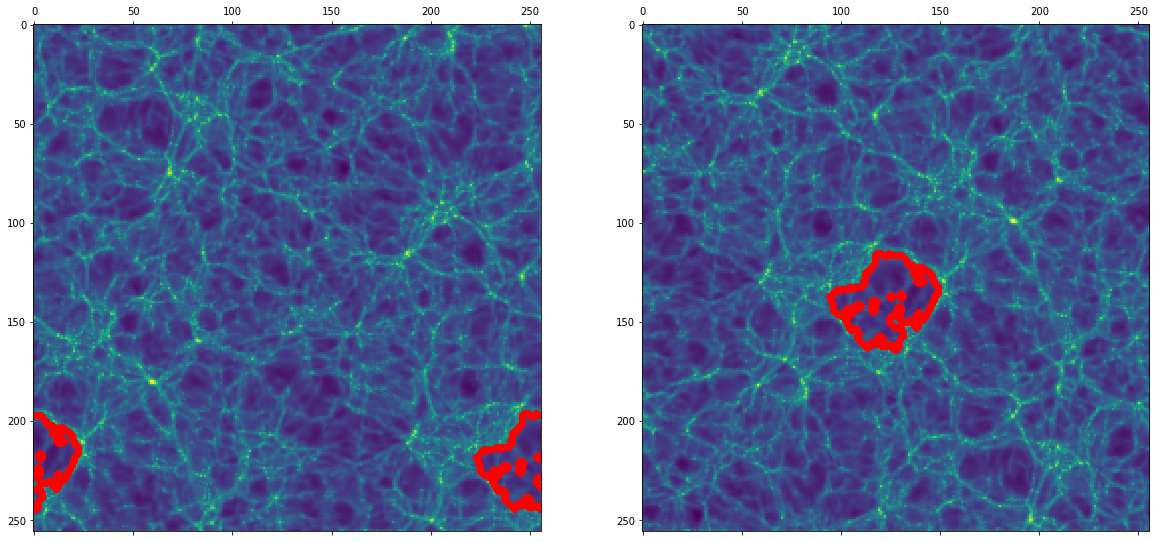

In [6]:
void_ellipse_list = []
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].matshow(density_slice)

contour, void = void_boundaries[1], void_list[1]

ax[0].scatter(*contour.T,c='r')

xv, yv = void[0], void[1] # void centre
vw, yw = void[2], void[3] # void wall
birth, death = void[4], void[5] # birth and death
# shift to centre, then shift back
shift = [L1//2 - int(xv),L2//2 - int(yv)]
contour = (contour + shift)%(L1,L2)
ax[1].matshow(np.roll(density_slice,shift,(1,0)))
ax[1].scatter(*contour.T,c='r')

## Loop through all voids

In the plot we procude, each void boundary is coloured the same as the ellipse we fit. We see that in many cases, larger voids will contain (several) smaller, nested voids. This is one of the advantages of using TDA, as we can use it to gain insight into hierarchical processes leading to the formation of a multi-scale structure. We see this expressed here in the variety of void sizes and shapres.

  0%|          | 0/498 [00:00<?, ?it/s]

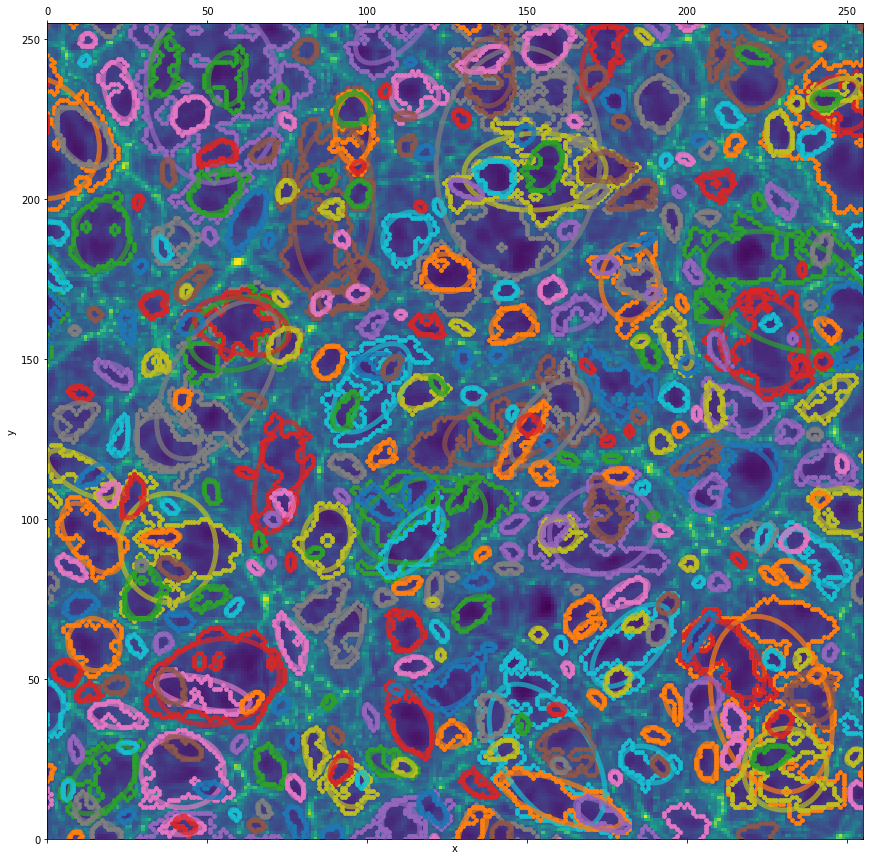

In [7]:
void_ellipse_list = []
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.matshow(density_slice)
# for contour, void_centre in zip(tqdm(void_boundaries),void_coordinates):
for contour, void in zip(tqdm(void_boundaries),void_list):
    xv, yv = void[0], void[1] # void centre
    vw, yw = void[2], void[3] # void wall
    birth, death = void[4], void[5] # birth and death
    # shift to centre, then shift back afterwards
    shift = [L1//2 - xv,L2//2 - yv]
    contour = (contour + shift)%(L1,L2)
    # too small contours are bad
    if len(contour) > 5:
        # initialise the model
        ellipse = EllipseModel()
        # least squares fit, store if it succesfully produces an ellipse
        if ellipse.estimate(contour):
            # get points of the fit ellipse for plotting
            ellipse_points = ellipse.predict_xy(np.linspace(0,2*np.pi)) - shift
            # calculate root-mean-square deviation
            RMSD = np.mean(ellipse.residuals(contour)**2)**0.5
            # store ellipse parameters, including the RMSD (accuracy of fit)
            # xc, yc are the coordinates of the centre
            # a, b are the semi-major and semi-minor axes
            # theta is the orientation
            xc, yc, a, b, theta =  ellipse.params
            if a < b: # to allow easier calculation of eccentricities later on
                a, b = b, a
            # here we shift back
            xc, yc = np.array([xc, yc]) - shift
            void_ellipse_list.append([xv, yv, vw, yw, birth, death, xc, yc, a, b, theta, RMSD])
            # plot
            ax.scatter(*((contour-shift)%(L1,L2)).T,s=15)
            ax.plot(*ellipse_points.T,linewidth=5,alpha=0.7)
ax.set_xlim(0,255)
ax.set_ylim(0,255)
ax.set_xlabel(r'x');
ax.set_ylabel(r'y');

# convert to numpy array for easier analysis and plotting later on
void_ellipse_list = np.array(void_ellipse_list)
    # 0... void centre location x
    # 1... void centre location y
    # 2... void saddle location x
    # 3... void saddle location y
    # 4... void birth
    # 5... void death
    # 6... ellipse: xc
    # 7... ellipse: yc
    # 8... ellipse: a
    # 9... ellipse: b
    # 10...ellipse: theta
    # 11...ellipse: residual

## Shape analysis

We can now analyse the shapes of the voids in this two-dimensional slice. This could be relations between the eccentricity $e$

$e = \sqrt{1 - \left(\frac{b}{a}\right)^2}$    ,

or the persistence $\pi$:

$\pi =$ birth - death

The persistence of a void denotes the difference between the density at which it is *born* and and at which it *dies*. Essentielly, it tells us how deep or prominent a void is. Alternatively, we could also look at the circumference (of the void or the ellipse), their size (e.g., an average radius), their central density, or whether a void contains nested sub-voids.

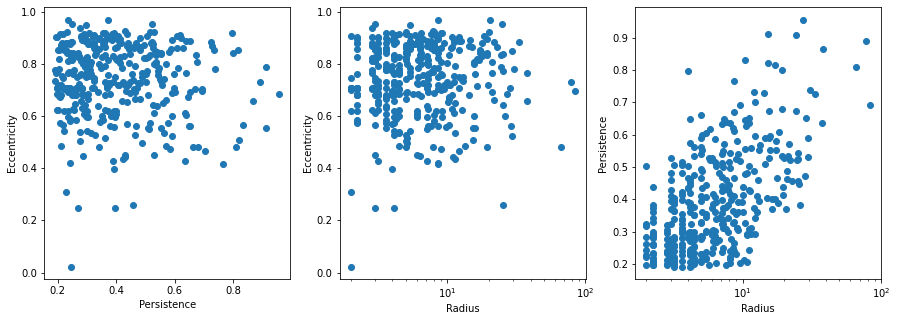

In [8]:
# compute a few attributes of voids and the fitted ellipses
eccentricity = np.sqrt(1-(void_ellipse_list[:,9]/void_ellipse_list[:,8])**2)
persistence = void_ellipse_list[:,4]-void_ellipse_list[:,5]
# size, as the difference between central minimum and saddle point
diff_vec = (void_ellipse_list[:,2:4] - void_ellipse_list[:,:2])
# to consider periodicy
approxradius = ((np.abs(diff_vec) <= np.abs(diff_vec - 256*np.sign(diff_vec))) * (diff_vec)
             + (np.abs(diff_vec) > np.abs(diff_vec - 256*np.sign(diff_vec))) * (diff_vec - 256*np.sign(diff_vec)))
approxradius = np.sum(approxradius**2,axis=1)**0.5

fig, ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(persistence,eccentricity)
ax[1].scatter(approxradius,eccentricity)
ax[2].scatter(approxradius,persistence)

# ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')

ax[0].set_xlabel('Persistence');
ax[1].set_xlabel('Radius');
ax[2].set_xlabel('Radius');
ax[0].set_ylabel('Eccentricity');
ax[1].set_ylabel('Eccentricity');
ax[2].set_ylabel('Persistence');

In two dimensions, we find the not so surprising result that the size of the void correlates with its depth. The analysis here is of course distorted by the fact that we're analysing a slice, and that the "voids" we oberve and analyse are merely *intersections* of actual, three-dimensional voids. We likely do not recover their correct centre, size, and shape.

Still, the concept and results of the ellipse fitting works nicely in two dimensions, and serves to outline the method.